In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import math
import matplotlib.patches as patches
from arena import *
import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import mutual_info_regression as mi_skl
import seaborn as sns
from scipy import stats
import time
from matplotlib import gridspec
from math import pi
from collections import Counter
from scipy.spatial import distance
from tqdm import tqdm, trange

#### Fraction of common cells starting from different SBS
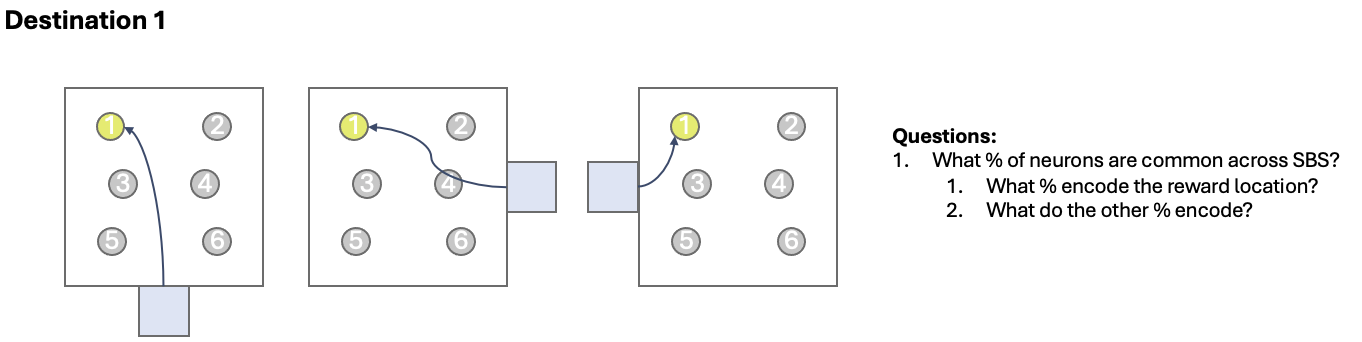

To do:
For allo phase, compare within a single session. Involves matching the same destination from other SBs. Start with All cells, then separate out into RW & trajectory cells. .

Extra Notes include:
1. Annotate North trials so that they can be separated out.
2. Start with allo within sessions, then move to across sessions
3. For ego compare common cells across sessions 
4. Plot sample and choice separately


In [ ]:
#codeDir = os.getcwd()
#len2del = sum([len(i) for i in codeDir.split('/')[-2:]])+1
#homeDir = codeDir[:-len2del]

#in this example data
homeDir = r'C:\Users\fr87_\OneDrive - University of Edinburgh\arena room files\ANALYSIS 2.0\Code\Gobbo et al. Code' #os.getcwd() 


In [ ]:
#ADD IN CONDITON THAT THERE ARE NO SB CELLS

In [ ]:
#Animals = ['H2231', 'H2224','H2225', 'H2226', 'H2230', 'H2234', 'H2235', 'H2241'] #Note H2222 is emmited from the analysis due to low # cells identified
#change here for animals in example data
Animals =['H2226']
Behaviour_phase = 'Ego' #Choose 'Ego' or 'Allo'

# Loop through all animals and phases
for Animal_ID in Animals:
    
    #Create animal D 
    Frac_common_cells = pd.DataFrame({'Animal':[], 
                                      'Phase':[], 
                                      'Ref Session':[], 
                                      'Ref Stage':[], 
                                      'Ref trial':[], 
                                      'Ref trial status':[], 
                                      'Ref rewarded well':[], 
                                      'Ref trial startbox':[], 
                                      'Ref n cells':[],
                                      'Com Session':[], 
                                      'Com Stage':[], 
                                      'Com trial':[], 
                                      'Com trial status':[], 
                                      'Com rewarded well':[], 
                                      'Com trial startbox':[],
                                      'Fraction of common cells':[]})

    ANIDir = homeDir + '\\Example Data\\' + Animal_ID 
    for Ego_Allo in os.listdir(ANIDir):
        if Ego_Allo.endswith(Behaviour_phase):
            Phase = Ego_Allo[2]
            print(Animal_ID,Phase)
            EVEdir = homeDir + '\\Example Data\\%s\\%s\\ALIGNED TRA EVE\\REGISTERED\\Events\\Quality_checked'  %(Animal_ID, Ego_Allo)
            SaveTo = homeDir + '\\Example Data\\SB_common_cells' #destination folder of choice
            All_META = pd.read_csv(EVEdir + '\\%s_all_trials.csv' %(Animal_ID))
            
            #Loop through each session and stage
            for ref_session in np.unique(All_META['Session']):
                for ref_stage in ['SAM', 'CHO']:
                    ref_meta = All_META.loc[(All_META['Session']==ref_session) & (All_META['Stage'].str.contains(ref_stage))]                 
                    for ref_trial in np.unique(ref_meta['Trial']): #Loop through each trial within the stage
                        print(ref_session, ref_stage, int(ref_trial),'--------------') 
                        ref_trial_meta = ref_meta[ref_meta['Trial']==ref_trial]
                        ref_status = ref_trial_meta['Trial Status'].iloc[0]
                        ref_rw = ref_trial_meta['Rewarded well'].iloc[0]
                        ref_sb = ref_trial_meta['Trial Startbox'].iloc[0]
                        ref_cells = ref_trial_meta[[i for i in ref_trial_meta.columns if i.startswith(' C')]]
                        ref_cells = ref_cells.loc[:, ref_cells.sum() > 0].columns
                        ref_ncells = len(ref_cells)
                        if ref_ncells > 0: #only consider reference trials with cells firing
                            c_session = []; c_stage = []; c_trial = []; com_status = []; com_rw = []; com_sb = []; frac_common_cells = []
                            for com_session in np.unique(All_META['Session']):
                                for com_stage in ['SAM', 'CHO']:
                                    com_meta = All_META.loc[(All_META['Session']==com_session) & (All_META['Stage'].str.contains(com_stage))]
                                    for com_trial in np.unique(com_meta['Trial']):
                                        print(com_session, com_stage, int(com_trial))
                                        c_session.append(com_session); c_stage.append(com_stage); c_trial.append(int(com_trial))
                                        com_trial_meta = com_meta[com_meta['Trial']==com_trial]
                                        com_status.append(com_trial_meta['Trial Status'].iloc[0])
                                        com_rw.append(com_trial_meta['Rewarded well'].iloc[0])
                                        com_sb.append(com_trial_meta['Trial Startbox'].iloc[0])
                                        com_cells = com_trial_meta[[i for i in com_trial_meta.columns if i.startswith(' C')]]
                                        com_cells = com_cells.loc[:, com_cells.sum() > 0]
                                        common_cells = list(set(ref_cells) & set(com_cells))
                                        frac_common_cells.append(len(common_cells)/ref_ncells)

                            Frac_common_cells = pd.concat([Frac_common_cells, 
                                                           pd.DataFrame({'Animal':Animal_ID, 'Phase':Phase, 
                                                                         'Ref Session':ref_session, 'Ref Stage':ref_stage, 'Ref trial':int(ref_trial), 'Ref trial status':ref_status, 'Ref rewarded well':ref_rw, 'Ref trial startbox':ref_sb, 'Ref n cells':ref_ncells,
                                                                         'Com Session':c_session, 'Com Stage':c_stage, 'Com trial':c_trial, 'Com trial status':com_status, 'Com rewarded well':com_rw, 'Com trial startbox':com_sb,
                                                                         'Fraction of common cells':frac_common_cells})])
    #unhash to save
    #Frac_common_cells.to_csv(os.path.join(SaveTo, '%s_%s_fraction_common_cells.csv' %(Animal_ID, Phase)), index=False)